#### ADS Data Cleaning<br>
[Aerial Detection Survey](https://www.fs.usda.gov/foresthealth/applied-sciences/mapping-reporting/detection-surveys.shtml)
###### Detection surveys are the primary method of collecting data on the health of treed areas affected by insects and diseases. Aerial and ground surveys using applications like Digital Mobile Sketch Mapping (DMSM) and Southern Pine Beetle (SPB) Collector Map are conducted annually. Geospatial data collected with these systems is stored in a National Insect and Disease Survey (IDS) database.

In [30]:
# import modules
import pandas as pd
import geopandas as gpd
import os

# import modules
import ee
import geemap
import geopandas as gpd
import rasterio as ras
import numpy as np
import json
import requests
import os
from datetime import datetime
import glob
from zipfile import ZipFile
from zipfile import BadZipfile
from shapely.geometry import box
from shapely.geometry import Polygon
from osgeo import gdal, ogr, osr
from matplotlib import pyplot as plt
import rasterio as ras

# initialization and authentication
#ee.Authenticate()
ee.Initialize()

In [4]:
#ee.Authenticate()

<Axes: >

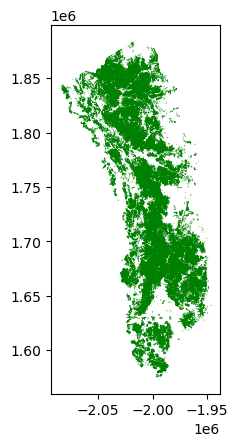

In [31]:
# open ADS an Southern Sierra Nevada (SSN) 
ads_df = gpd.read_file('./input/Damage_Area_All_years.shp')
# SN shape
sn_shp = gpd.read_file('./input/Southern_Sierra.shp')
ads_df.plot(color='green')

In [33]:
ads_df.columns

Index(['OBJECTID', 'DAMAGE_ARE', 'CREATED_DA', 'MODIFIED_D', 'FEATURE_US',
       'OBSERVATIO', 'REGION_ID', 'LABEL', 'HOST_CODE', 'HOST', 'HOST_GROUP',
       'HOST_GRO_1', 'DCA_CODE', 'DCA_COMMON', 'DAMAGE_TYP', 'DAMAGE_T_1',
       'PERCENT_AF', 'PERCENT__1', 'PERCENT_MI', 'PERCENT_MA', 'PERCENT__2',
       'NOTES', 'OBSERVAT_1', 'COLLECTION', 'SNAPGRID_R', 'SNAPGRID_C',
       'AREA_TYPE', 'ACRES', 'STATUS', 'SURVEY_YEA', 'LEGACY_SEV',
       'LEGACY_S_1', 'LEGACY_PAT', 'LEGACY_P_1', 'LEGACY_TPA', 'LEGACY_NO_',
       'LEGACY_FOR', 'LEGACY_F_1', 'GRP', 'OBSERVAT_2', 'IDS_DATA_S',
       'DATA_SOURC', 'US_AREA', 'SHAPE_Leng', 'SHAPE_Area', 'geometry'],
      dtype='object')

##### Selecting data for SSN after 2010 and droping all NA data and Subset a random sapmle from the dataset

In [34]:
# cleanup the data frame
ads_complete = ads_df[['OBJECTID','HOST_CODE',
                 'HOST', 'DCA_CODE', 'DCA_COMMON',
                 'DAMAGE_TYP','DAMAGE_T_1', 'PERCENT_AF',
                 'PERCENT__1', 'ACRES', 'SURVEY_YEA','geometry']]
ads_complete.head()
# year filter
ads_dfyear = ads_complete[ads_complete.SURVEY_YEA >= 2010]
ads_dfy = ads_dfyear.copy()
# replace -1 from nans 
ads_dfy.replace(-1, float('nan'), inplace=True)
# drop nas
ads_dfy = ads_dfy.dropna()
# sample a set of data from this data set
seed = 42
ads_sample  = ads_dfy.sample(n=300, random_state=seed)
# Add a uid column
id = [numb for numb in range(1, 301)]
ads_sample['id'] = id
ads_sample.head()


,OBJECTID,HOST_CODE,HOST,DCA_CODE,DCA_COMMON,DAMAGE_TYP,DAMAGE_T_1,PERCENT_AF,PERCENT__1,ACRES,SURVEY_YEA,geometry,id
44300,315464.0,122.0,ponderosa pine,11002,western pine beetle,2.0,Mortality,3.0,Moderate (11-29%),54.43,2021,"POLYGON ((-2033888.104 1853315.120, -2033817.4...",1
44393,319751.0,122.0,ponderosa pine,11002,western pine beetle,2.0,Mortality,2.0,Light (4-10%),1164.45,2022,"POLYGON ((-1988393.633 1604934.532, -1988578.5...",2
43559,313801.0,116.0,Jeffrey pine,11004,Jeffrey pine beetle,2.0,Mortality,3.0,Moderate (11-29%),4.70,2020,"POLYGON ((-2021339.844 1854789.385, -2021338.8...",3
43272,305942.0,20.0,California red fir,11050,fir engraver,2.0,Mortality,2.0,Light (4-10%),96.83,2019,"POLYGON ((-1992129.547 1792503.677, -1992120.1...",4
44236,315261.0,20.0,California red fir,11050,fir engraver,2.0,Mortality,3.0,Moderate (11-29%),20.99,2021,"POLYGON ((-1991433.759 1716783.888, -1991525.1...",5


<Axes: >

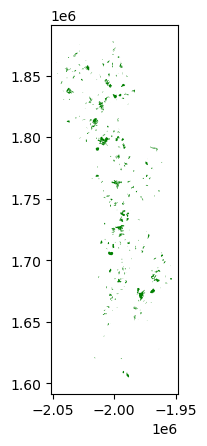

In [35]:
ads_sample.plot(color='green')

In [36]:
#ads_sample.to_file('./output/shapes/ADS_sample.shp')

In [37]:
ads_sample = ads_sample.to_crs('EPSG:4326')
ads_sample = ads_sample#[56:57]
ads_sample.head()

,OBJECTID,HOST_CODE,HOST,DCA_CODE,DCA_COMMON,DAMAGE_TYP,DAMAGE_T_1,PERCENT_AF,PERCENT__1,ACRES,SURVEY_YEA,geometry,id
42573,305003.0,20.0,California red fir,11050,fir engraver,2.0,Mortality,3.0,Moderate (11-29%),92.41,2019,"POLYGON ((-118.73066 36.37210, -118.73058 36.3...",57


### Google Earth Engine - MODIS LAI product operations
###### product guide MODIS  [MODIS-LAI](https://lpdaac.usgs.gov/documents/624/MOD15_User_Guide_V6.pdf)

In [38]:
# time window # permemant mask
start_dt = '2000-05-01'
end_dt   = '2023-12-31'

In [39]:
# Define the function to create the cloud mask and apply it
def apply_cloud_mask(image, quality_band):
    # Define bitmasks for each quality flag
    CLOUDSTATE_MASK = 0b00011000

    # Extract the cloud state bitfield using bitwise AND
    cloud_state = image.select(quality_band).bitwiseAnd(CLOUDSTATE_MASK).rightShift(3)

    # Create a cloud mask for clouds only
    cloud_mask = cloud_state.eq(1)

    # Apply the cloud mask to the original image
    masked_image = image.updateMask(cloud_mask.Not())
    masked_image = image.where(cloud_mask, 0).where(cloud_mask.Not(), image)

    return masked_image

#### Downloading without creating composite images

In [40]:
for index, row in ads_sample.iterrows():
    # Extract corner coordinates
    corners = list(row['geometry'].exterior.coords)
    new_polygon = Polygon(corners)

    # create ee geometry
    #aoi  = ee.Geometry.Polygon(new_polygon)
    aoi  = ee.Geometry.Polygon([list(coord) for coord in corners])
    modis_collection = ee.ImageCollection("MODIS/061/MOD15A2H").filterBounds(aoi).filterDate(start_dt, end_dt)
    # summer collection
    summer_collection = modis_collection.filter(ee.Filter.calendarRange(6, 8, 'month'))
    # QC band name
    quality_band_name = 'FparLai_QC'
    # cloud masking
    modis_lai_masked = summer_collection.map(lambda img:apply_cloud_mask(img, quality_band_name))

    # images to a list
    image_list = modis_lai_masked .toList(modis_lai_masked .size())
    # take image list and gothrough each of them for download

    # create folder for images
    ads_id = row['id']
    folder_path  = './output/images/'+str(ads_id)
    print(folder_path)
    # create folders
    try:
        os.makedirs(folder_path)
    except:
        print('Folder in place already')
    # number of images in collection for aoi
    num_images = modis_lai_masked.size().getInfo()
    for item in range(0, num_images):
        # take images
        filter_image = ee.Image(image_list.get(item))
        # take band
        filter_band = filter_image.select(['Lai_500m'])
        # clip to aoi
        filter_band = filter_band.clip(aoi)#.unmask()
        # image name
        im_name = str(filter_band.get('system:index').getInfo())
        #print(im_name)
        # take url
        try:
            url = filter_band.getDownloadURL({'scale':500,
                                                    'filePerBand':False, 
                                                    'region':aoi,
                                                    'crs':'EPSG:26911', 
                                                    'maxPixels': 1e13})
            #print(url)
            r = requests.get(url)
            with open(folder_path+'/'+im_name+'.zip', 'wb') as f:
                f.write(r.content)
        except:
            print('no images avialable')
            continue
        # extract the zipfile here
        zip_file = glob.glob('./output/images/'+str(ads_id)+'/*zip')
        try:
            zf = ZipFile(zip_file[0])
            zf.extractall('./output/images/'+str(ads_id))
            os.remove(zip_file[0])
        except BadZipfile:
            print()
            os.remove(zip_file[0])
        

./output/images/57
Folder in place already


In [120]:
# taking images and taking statistics
image_list = os.listdir('./output/images/281')
image_list = [item for item in image_list if 'tif' in item]
image_list

['2019_11_09.tif',
 '2019_08_29.tif',
 '2019_06_10.tif',
 '2019_01_25.tif',
 '2019_04_15.tif',
 '2019_03_22.tif',
 '2019_08_13.tif',
 '2019_06_02.tif',
 '2019_04_07.tif',
 '2019_03_30.tif',
 '2019_01_09.tif',
 '2019_08_05.tif',
 '2019_11_25.tif',
 '2019_10_16.tif',
 '2019_02_02.tif',
 '2019_09_22.tif',
 '2019_05_09.tif',
 '2019_12_11.tif',
 '2019_07_20.tif',
 '2019_02_10.tif',
 '2019_05_25.tif',
 '2019_09_30.tif',
 '2019_12_03.tif',
 '2019_05_17.tif',
 '2019_12_27.tif',
 '2019_07_12.tif',
 '2019_07_04.tif',
 '2019_10_08.tif',
 '2019_12_19.tif',
 '2019_05_01.tif',
 '2019_09_14.tif',
 '2019_02_18.tif',
 '2019_10_24.tif',
 '2019_07_28.tif',
 '2019_02_26.tif',
 '2019_09_06.tif',
 '2019_03_14.tif',
 '2019_08_21.tif',
 '2019_06_18.tif',
 '2019_11_01.tif',
 '2019_11_17.tif',
 '2019_06_26.tif',
 '2019_04_23.tif',
 '2019_03_06.tif',
 '2019_01_17.tif',
 '2019_01_01.tif']

In [122]:
for image in image_list:
    #print(image)
    f_path = './output/images/281/'+image
    src = ras.open(f_path)
    lai_band = src.read(1)
    if np.any(lai_band == 0):
        continue
    else:
       print(image)
    #print(lai_band)
    # Close the raster file
    src.close()
    #print('*************************')

2019_11_09.tif
2019_06_10.tif
2019_08_13.tif
2019_08_05.tif
2019_10_16.tif
2019_09_22.tif
2019_07_20.tif
2019_09_30.tif
2019_12_03.tif
2019_07_12.tif
2019_07_04.tif
2019_10_08.tif
2019_09_14.tif
2019_10_24.tif
2019_07_28.tif
2019_09_06.tif
2019_08_21.tif
2019_06_18.tif
2019_11_01.tif
2019_11_17.tif
2019_06_26.tif


#### create annual composite images for summer months

In [145]:
# ...

for index, row in ads_sample.iterrows():
    # Extract corner coordinates
    corners = list(row['geometry'].exterior.coords)
    new_polygon = Polygon(corners)

    # create ee geometry
    aoi = ee.Geometry.Polygon([list(coord) for coord in corners])
    modis_collection = ee.ImageCollection("MODIS/061/MOD15A2H").filterBounds(aoi).filterDate(start_dt, end_dt)
    
    # QC band name
    quality_band_name = 'FparLai_QC'
    
    # Create empty ImageCollection to store annual composites
    annual_composites = ee.ImageCollection([])

    # Iterate over years
    for year in range(2019, 2023):
        # Filter by year
        year_collection = modis_collection.filter(ee.Filter.calendarRange(year, year, 'year'))
        
        # Filter summer months
        summer_collection = year_collection.filter(ee.Filter.calendarRange(6, 8, 'month'))
        
        # Cloud masking
        modis_lai_masked = summer_collection.map(lambda img: apply_cloud_mask(img, quality_band_name))
        

        # Create composite for the year
        composite_image = modis_lai_masked.reduce(ee.Reducer.median())

        # Add the composite to the collection
        annual_composites = annual_composites.merge(composite_image)

        # images to a list
    image_list = annual_composites.toList(annual_composites.size())
    # take image list and gothrough each of them for download

    # create folder for images
    ads_id = row['id']
    folder_path  = './output/images/'+str(ads_id)
    print(folder_path)
    # create folders
    try:
        os.makedirs(folder_path)
    except:
        print('Folder in place already')
    # number of images in collection for aoi
    num_images = annual_composites.size().getInfo()
    for item in range(0, num_images):
        # take images
        filter_image = ee.Image(image_list.get(item))
        # take band
        filter_band = filter_image.select(['Lai_500m_median'])
        # clip to aoi
        filter_band = filter_band.clip(aoi)#.unmask()
        # image name
        im_name = str(filter_band.get('system:index').getInfo())

        #print(im_name)
        # take url
        try:
            url = filter_band.getDownloadURL({'scale':500,
                                                    'filePerBand':False, 
                                                    'region':aoi,
                                                    'crs':'EPSG:26911', 
                                                    'maxPixels': 1e13})
            #print(url)
            r = requests.get(url)
            with open(folder_path+'/'+im_name+'.zip', 'wb') as f:
                f.write(r.content)
        except:
            print('no images avialable')
        # extract the zipfile here
        zip_file = glob.glob('./output/images/'+str(ads_id)+'/*zip')
        zf = ZipFile(zip_file[0])
        zf.extractall('./output/images/'+str(ads_id))
        # remove zipfile
        os.remove(zip_file[0])



./output/images/281
Folder in place already
./output/images/282
Folder in place already


In [141]:
annual_composites

In [146]:
image_list